In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
# Import libraries
import os, codecs
#NLP libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [3]:
# Load the script
with codecs.open(os.path.join('data/', 'all_scripts.txt'),encoding="utf8") as file:
    content = file.read()

data = []
columns = ['Episode','Scene','Character','Sentence']

# Split the script into episodes
episodes = content.split('>>')

for episode in episodes[1:]:
    # Keep only the episode title
    episode_title = episode.split('\n')[0].strip()
    # Split the episode into scenes
    scenes = episode.split('>')

    for scene in scenes[1:]:
        # Keep only the scene title
        scene_title = scene.split('\n')[0].strip()
        # Split the scene into sentences
        sentences = scene.split('\n')

        for sentence in sentences[1:]:
            # Store name of character speaking
            name = sentence.split(':')[0].strip()
            # Remove character name from sentence
            sentence_text = sentence.replace(name + ':', '').strip()
            # Add the sentence to the dataframe
            data.append((episode_title, scene_title, name, sentence_text))
            
# Create a dataframe to store the data
df = pd.DataFrame(data, columns=columns)
df


,Episode,Scene,Character,Sentence
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.
...,...,...,...,...
54093,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Ramona,What if I were?
54094,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,Sheldon,"Well, that would raise a number of problems. W..."
54095,Series 10 Episode 24 – The Long Distance Disso...,Sheldon’s office.,,
54096,Series 10 Episode 24 – The Long Distance Disso...,Princeton.,Sheldon,"(Knock, knock, knock) Amy. (Knock, knock, knoc..."


In [4]:
# We now need to count how many scenes are there in each season. 
# Creating a new dataframe to store the data

df['Season Number'] = df['Episode'].str.extract(r'Series (\d+)').astype(int)
df_scene_count = df.groupby(['Season Number', 'Episode'])['Scene'].nunique().reset_index(name='Scene count')
df_season_scene_count = df_scene_count.groupby('Season Number')['Scene count'].sum().reset_index()

df_season_scene_count


,Season Number,Scene count
0,1,157
1,2,206
2,3,193
3,4,219
4,5,198
5,6,211
6,7,208
7,8,192
8,9,177
9,10,190


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [5]:
# Filter the dataframe to keep only those with more than 90 dialogues
lines_count = df.groupby('Character').count()[['Sentence']]
recurrent_characters = lines_count[lines_count['Sentence'] > 90]

recurrent_characters

,Sentence
Character,
,2806
Amy,3472
Arthur,130
Bernadette,2690
Bert,95
Beverley,162
Emily,164
Howard,5872
Kripke,106


In [6]:
# Droping the first row as it is not a character
#recurrent_characters = recurrent_characters[1:]
recurrent_characters = recurrent_characters.drop('Man', axis=0)
display(recurrent_characters)

,Sentence
Character,
,2806
Amy,3472
Arthur,130
Bernadette,2690
Bert,95
Beverley,162
Emily,164
Howard,5872
Kripke,106


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [7]:
# Replacing punctuation marks with whitespaces
df['Sentence'] = df['Sentence'].apply(
    lambda text: ''.join(' ' if char in EXCLUDE_CHARS else char for char in text)
)
df['Sentence'] = df['Sentence'].str.lower()

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [8]:
# Importing the corpus counter 
from collections import Counter

# Tokenizing the sentences
nlp = spacy.load('en_core_web_sm')
all_tokens = []

for sentence in df['Sentence']: 
    doc = nlp(sentence)
    all_tokens.extend([token.text for token in doc])

word_freq = Counter(all_tokens)

common_words = word_freq.most_common(20)

/var/folders/46/vyrbyq5s6hgb0v2dmb40b_cw0000gn/T/ipykernel_6932/3116460712.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


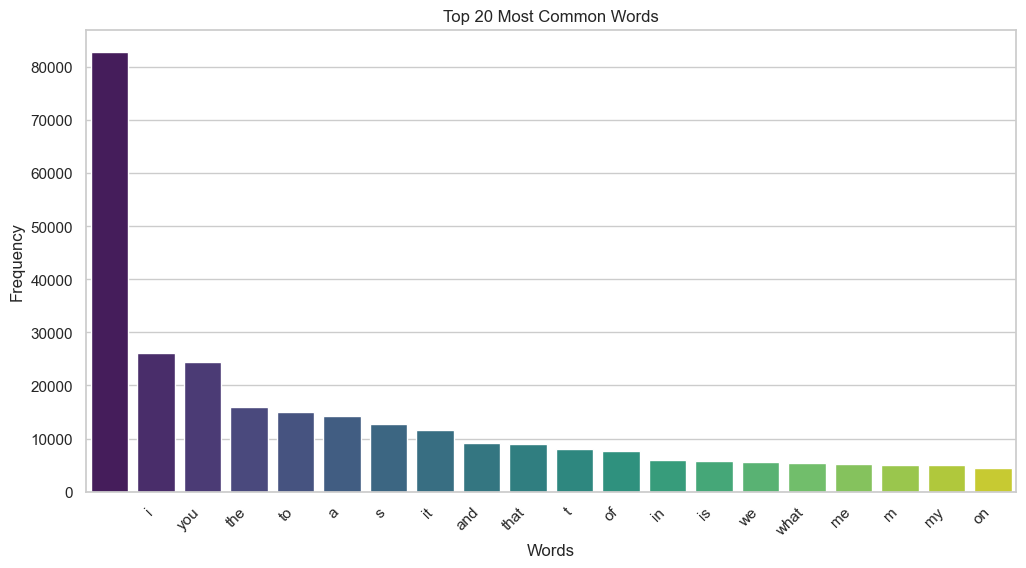

In [9]:
# Plotting the distributuion of corpus frequency using a histogram 
import seaborn as sns

words, counts = zip(*common_words)

# Plot with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

All of them are fucking stopwords

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [10]:
# Filtering the initial DF to keep only recurrents character 
df = df[df['Character'].isin(set(recurrent_characters.index))]

grouped = df.groupby('Character')['Sentence'].apply(lambda x: ' '.join(x))

# Count the number of words for each character
word_counts = grouped.apply(lambda x: len(x.split()))

# Convert to DataFrame for readability
word_counts_df = word_counts.reset_index()
word_counts_df.columns = ['Character', 'Word Count']

# Sort by word count in descending order
word_counts_df = word_counts_df.sort_values(by='Word Count', ascending=False)

# Display the result
print(word_counts_df)


       Character  Word Count
16       Sheldon      185381
9        Leonard      102496
13         Penny       79270
7         Howard       69505
15           Raj       60099
1            Amy       39929
3     Bernadette       27724
17        Stuart        7955
11    Mrs Cooper        3389
5       Beverley        2029
14         Priya        1940
18           Wil        1678
6          Emily        1571
12  Mrs Wolowitz        1459
2         Arthur        1451
19          Zack        1427
10        Leslie        1249
8         Kripke        1246
4           Bert        1146
0                          0


The most talkative character seems to be Sheldon. 

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [ ]:
# Combining all sentences from every season except the last two only for recurrent characters: 
training_set = df[df['Season Number'] < 9]

test_set = df[df['Season Number'] > 8]

training_set

,Episode,Scene,Character,Sentence,Season Number
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...,1
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point,1
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...,1
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me,1
5,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,one across is aegean eight down is nabakov t...,1
...,...,...,...,...,...
42472,Series 08 Episode 24 – The Commitment Determin...,The apartment.,Amy,i hope you understand,8
42473,Series 08 Episode 24 – The Commitment Determin...,The apartment.,Sheldon,okay,8
42474,Series 08 Episode 24 – The Commitment Determin...,The apartment.,Amy,bye sheldon,8
42475,Series 08 Episode 24 – The Commitment Determin...,The apartment.,Sheldon,well gollum you re an expert on rings what ...,8


**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [30]:
# Filter the training set for Sheldon's dialogue
sheldon_words_set = set()

for sentence in training_set[training_set['Character'] == 'Sheldon']['Sentence']:
    words = simple_tokeniser(sentence)
    for word in words:
        if word not in sheldon_words_set:
            sheldon_words_set.add(word)

# Now checking with all the other characters and removing the words that are common with Sheldon
for character in training_set['Character'].unique():
    if character != 'Sheldon':
        character_words_set = set()
        for sentence in training_set[training_set['Character'] == character]['Sentence']:
            words = simple_tokeniser(sentence)
            for word in words:
                if word not in character_words_set:
                    character_words_set.add(word)
        sheldon_words_set = sheldon_words_set.difference(character_words_set)

# Convert the set back to a list if you want to see the vocabulary
sheldon_vocab = list(sheldon_words_set)
len(sheldon_vocab)

5268

There are 5268 words that are only employed by Sheldon. I need now to perform a test to see if yes or not, Shedlon is able to recognize himself only based on his vocabulary.

In [35]:
# my labels are 1 for Sheldon and 0 for all other characters
# Step 1: Label the training data
training_set.loc[:, 'Label'] = training_set['Character'].apply(lambda x: 1 if x == 'Sheldon' else 0)
test_set.loc[:, 'Label'] = test_set['Character'].apply(lambda x: 1 if x == 'Sheldon' else 0)

# Convert text documents into numerical TF-IDF features
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(training_set['Sentence'])
X_test = vectorizer.transform(test_set['Sentence'])

# Apply TruncatedSVD (Dimensionality Reduction)
svd = TruncatedSVD(n_components=100)  # Reduce to 2 components
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

# Extract the labels
train_labels = training_set['Label']
test_labels = test_set['Label']

# Train Logistic Regression model with cross-validation
model = LogisticRegressionCV(max_iter=1000)
model.fit(X_train_reduced, train_labels)

# Make predictions
y_pred = model.predict(X_test_reduced)

# Evaluate the model
accuracy = model.score(X_test_reduced, test_labels)
print(f'Accuracy: {accuracy:.2f}')


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Accuracy: 0.80


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` i

Beaucoup trop compliqué pour ce que c'est mdrrr
Je refais en dessous. 

In [39]:
# Correction 
words_for_chars = pd.concat([pd.Series(row["Character"], row['Sentence'].split())
                             for _, row in training_set.iterrows()]).reset_index()
words_for_chars.columns = ["Word", "Character"]

words_for_chars = words_for_chars.groupby("Word")["Character"].apply(set)
sheldon_words = words_for_chars[words_for_chars.apply(lambda x: ("Sheldon" in x) and (len(x) == 1))].index

sheldon_words

Index(['000lb', '01100111', '0700', '08', '102', '112', '114', '1175', '11n',
       '11pm',
       ...
       '“sarcasm”', '“thanks', '“waltz”', '“with', '“world', '“would', '“ye',
       '…playing', '…the', '…tion'],
      dtype='object', name='Word', length=5268)

We have exactly the same words, so my implementation is correct. 

In [ ]:
def contains_sheldon_words(line):
    for word in sheldon_words: 
        if word in line.split():
            return True
    return False
test_pred = test_set["Sentence"].apply(contains_sheldon_words)
test_true = test_set["Character"] == "Sheldon"

print("Accuracy: ", (test_true == test_pred).sum() / len(test_true))

Accuracy:  0.7844636933284187
